In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import time
import datetime
from playsound import playsound

from misc.utils import MyUtils
from code_linear_regression.linear_regression import LinearRegression

In [2]:
# training config
max_degree = 1
training_epochs = 100
eta_list = [0.01, 0.001, 0.0001]
lam_list = [0.1, 0.01, 0.001] 

# dataset config
normalize_neg1_pos1 = False
normalize_zero_one = True
num_samples = None # set to None for all samples

### Pre-Process Our Dataset

In [3]:
data_path = "./dataset/houseprice"

X_train = pd.read_csv(os.path.join(data_path, "x_train.csv")).to_numpy()[:num_samples]
y_train = pd.read_csv(os.path.join(data_path, "y_train.csv")).to_numpy()[:num_samples]
X_test = pd.read_csv(os.path.join(data_path, "x_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(data_path, "y_test.csv")).to_numpy()

if normalize_neg1_pos1:
    X_train = MyUtils.normalize_neg1_pos1(X_train)
    y_train = MyUtils.normalize_neg1_pos1(y_train)
    X_test = MyUtils.normalize_neg1_pos1(X_test)
    y_test = MyUtils.normalize_neg1_pos1(y_test)
    
elif normalize_zero_one:
    X_train = MyUtils.normalize_0_1(X_train)
    y_train = MyUtils.normalize_0_1(y_train)
    X_test = MyUtils.normalize_0_1(X_test)
    y_test = MyUtils.normalize_0_1(y_test)

### Run Metric Calculations
For our training configurations in the above cells (`max_degree`, `training_epochs`, `eta_list`, and `lam_list`), we will train our model using gradient descent for all combinations of hyperparameters. The training results will be compiled into a dictionary and stored locally.

In [4]:
lr = LinearRegression()

results = [] # results will hold dict of (degree, epochs, eta, lam, train_mse, test_mse, y_hat)

for r in range(1, max_degree + 1):  # 1-based indexing
    print(f"degree {r}")
    
    print(f"\tepochs {training_epochs}")

    for eta_val in eta_list:
        print(f"\t\teta {eta_val}")

        for lam_val in lam_list:
            print(f"\t\t\tlam {lam_val}")

            start = time.time()
            train_mse, test_mse = lr.fit_metrics(X=X_train, y=y_train, X_test=X_test, y_test=y_test, epochs=training_epochs, eta=eta_val, degree=r, lam=lam_val)
            end = time.time()

            y_hat = lr.predict(X=X_test)

            result = {
                "degree": r,
                "epochs": training_epochs,
                "eta": eta_val,
                "lam": lam_val,
                "train_mse": train_mse,
                "test_mse": test_mse,
                "y_hat": list(y_hat.flatten()), # json doesnt like the nd-array
                "train_time": (end - start) # trainng time in seconds
            } 

            results.append(result)

            print(f"\t\t\tlam {lam_val} done;")

        print(f"\t\teta {eta_val} done;")

    print(f"\tepochs {training_epochs} done;")
        
    print(f"degree {r} done;")
        
assert len(results) == max_degree * len(eta_list) * len(lam_list)
print(f"\nnumber of training runs: {len(results)}")

# notification when done
playsound('./misc/training_done.mp3')

# store output
join_str = "-"
gd_output_filename = f"./output/{datetime.datetime.now()}_GD_degree-{max_degree}_epochs-{training_epochs}_eta-{join_str.join([str(int) for int in eta_list])}_lam-{join_str.join([str(int) for int in lam_list])}.json".replace(":", "-").replace(" ", "_")
with open(gd_output_filename, "w") as file:
    json.dump(results, file)

degree 1
	epochs 100
		eta 0.01
			lam 0.1
			lam 0.1 done;
			lam 0.01
			lam 0.01 done;
			lam 0.001
			lam 0.001 done;
		eta 0.01 done;
		eta 0.001
			lam 0.1
			lam 0.1 done;
			lam 0.01
			lam 0.01 done;
			lam 0.001
			lam 0.001 done;
		eta 0.001 done;
		eta 0.0001
			lam 0.1
			lam 0.1 done;
			lam 0.01
			lam 0.01 done;
			lam 0.001
			lam 0.001 done;
		eta 0.0001 done;
	epochs 100 done;
degree 1 done;

number of training runs: 9


## Visualization
### Load Model Training Output Data
From the previous section, we stored the model training outputs. We will use this cached data for visualization purposes. This is so we do not have to train our model every time before we want to analyze the results.

In [5]:
# uncomment the line below and change the file name when using a pre-existing output file
# gd_output_filename = "./output/2022-02-09 21-58-54.069122_GD_degree-3_epochs-100-1000-100000_eta-0.01-0.001-0.0001_lam-1.json" 

# load our data
with open(gd_output_filename, "r") as file:
    json_str = file.read()
gd_data = json.loads(json_str)

### Plotting Degree vs. MSE

Pseudo-Code for the algorithm below:
- for each degree
    - create fig, 
        
    - for the fig, create subplots; number of subplots = `len(lams) * len(etas) * 2`
    
    - for each $\eta$ value
        - on each subplot for $\eta$, plot all vals of $\lambda$ with legend

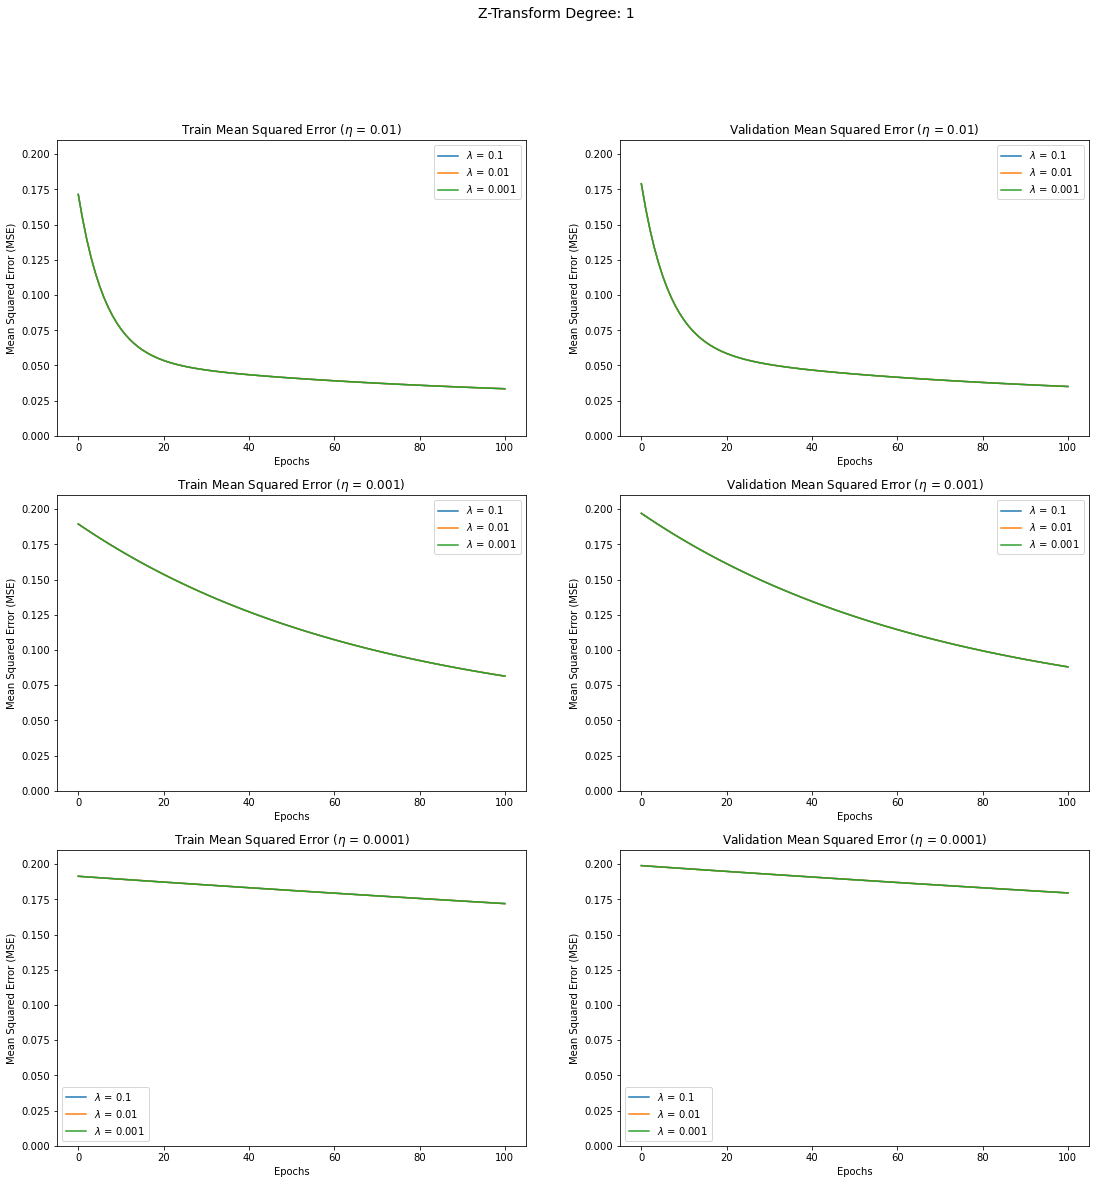

In [12]:
# plotting config
plot_output_path = "./output/plots/"
fixed_epochs = training_epochs
epoch_start_index = 0
epoch_end_index = 10_000
subplot_rows = len(eta_list)
subplot_cols = 2

# our x-axis
x_epochs = np.arange(fixed_epochs + 1)

# for each degree we create a figure
for r in np.arange(1, max_degree + 1):
    degree_fig = plt.figure()
    
    # figure config    
    degree_fig.set_size_inches(18.5, 18.5)
    degree_fig.suptitle(f'Z-Transform Degree: {r}', fontsize=14)
    
    # subplot for each eta value
    for i, eta_val in enumerate(eta_list):
        
        train_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 1)
        test_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 2)
        
        train_mse_ax.set_title(f"Train Mean Squared Error ($\eta$ = {eta_val})")
        train_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        train_mse_ax.set_xlabel("Epochs")
        
        test_mse_ax.set_title(f"Validation Mean Squared Error ($\eta$ = {eta_val})")
        test_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        test_mse_ax.set_xlabel("Epochs")

        # plot a line on the subplot for each lambda
        for lam_val in lam_list:
        
            y_val = list(filter(lambda x: 
                                x["degree"] == r and 
                                x["epochs"] == fixed_epochs and 
                                x["eta"] == eta_val and 
                                x["lam"] == lam_val, 
                                gd_data))
            
            y_train_mse = y_val[0]["train_mse"]
            y_test_mse = y_val[0]["test_mse"]

            train_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                              y_train_mse[epoch_start_index:epoch_end_index], 
                              label=f"$\lambda$ = {lam_val}")

            test_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                             y_test_mse[epoch_start_index:epoch_end_index], 
                             label=f"$\lambda$ = {lam_val}")

        train_mse_ax.legend()
        test_mse_ax.legend()
        
        train_mse_ax.set_ylim([0, 0.21])
        test_mse_ax.set_ylim([0, 0.21])    
        
    # save output
    degree_fig.savefig(f"{plot_output_path}/gd_fig_degree-{r}-LAM_legend.jpeg") # TODO: make better name

plt.show()

Previous cell logic but now subplots for each $\lambda$ plotting all $\eta$ values

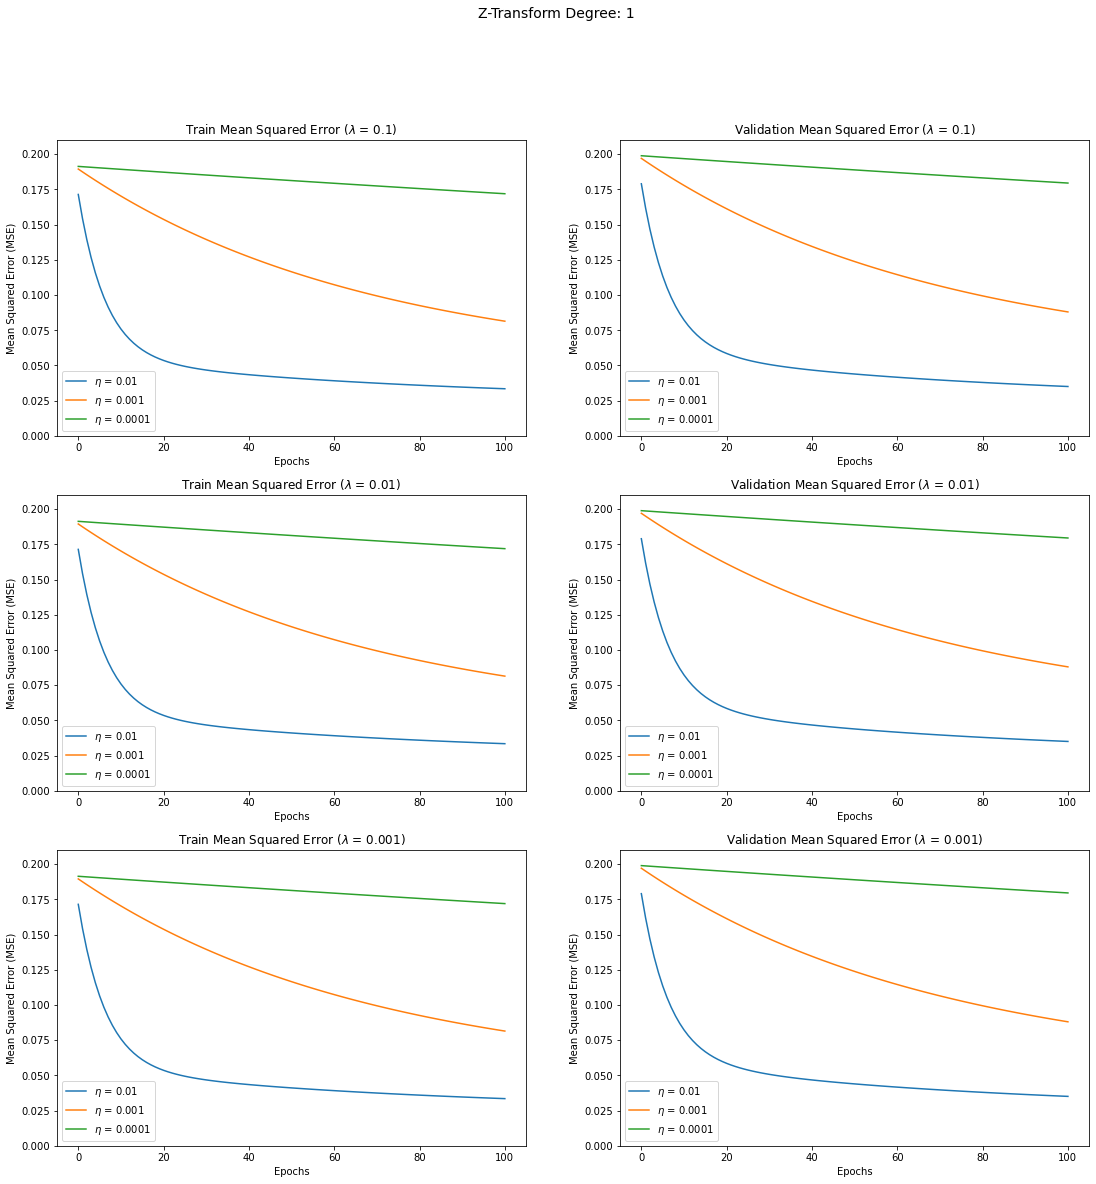

In [11]:
# plotting config
fixed_epochs = training_epochs
epoch_start_index = 0
epoch_end_index = 10_000
subplot_rows = len(eta_list)
subplot_cols = 2

# our x-axis
x_epochs = np.arange(fixed_epochs + 1)

# for each degree we create a figure
for r in np.arange(1, max_degree + 1):
    degree_fig = plt.figure()
    
    # figure config    
    degree_fig.set_size_inches(18.5, 18.5)
    degree_fig.suptitle(f'Z-Transform Degree: {r}', fontsize=14)
    
    # subplot for each eta value
    for i, lam_val in enumerate(lam_list):
        
        train_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 1)
        test_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 2)
        
        train_mse_ax.set_title(f"Train Mean Squared Error ($\lambda$ = {lam_val})")
        train_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        train_mse_ax.set_xlabel("Epochs")
        
        test_mse_ax.set_title(f"Validation Mean Squared Error ($\lambda$ = {lam_val})")
        test_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        test_mse_ax.set_xlabel("Epochs")

        # plot a line on the subplot for each lambda
        for eta_val in eta_list:
        
            y_val = list(filter(lambda x: 
                                x["degree"] == r and 
                                x["epochs"] == fixed_epochs and 
                                x["eta"] == eta_val and 
                                x["lam"] == lam_val, 
                                gd_data))
            
            y_train_mse = y_val[0]["train_mse"]
            y_test_mse = y_val[0]["test_mse"]

            train_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                              y_train_mse[epoch_start_index:epoch_end_index], 
                              label=f"$\eta$ = {eta_val}")

            test_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                             y_test_mse[epoch_start_index:epoch_end_index], 
                             label=f"$\eta$ = {eta_val}")

        train_mse_ax.legend()
        test_mse_ax.legend()
        
        train_mse_ax.set_ylim([0, 0.21])
        test_mse_ax.set_ylim([0, 0.21])
        
    # save output
    degree_fig.savefig(f"{plot_output_path}/gd_fig_degree-{r}-ETA_legend.jpeg") # TODO: make better name

plt.show()